In [1]:
# %load https://gist.githubusercontent.com/kidpixo/2ec078d09834b5aa7869/raw/c8812811211dc7cd62f5b530b51b0104f39263ff/ipython%20inizialization
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
commits_list = ! git -C test_git --no-pager log --reverse --oneline

commits = []
for i in commits_list:
    sha1 = i.split(' ')[0]
    print 'Commit SHA-1 value:',sha1
    commits.append(sha1)

Commit SHA-1 value: 7545477
Commit SHA-1 value: b904ffd
Commit SHA-1 value: 050a563
Commit SHA-1 value: e92be1e
Commit SHA-1 value: 976869c
Commit SHA-1 value: 39ab315
Commit SHA-1 value: 8ea5de7
Commit SHA-1 value: afa0783
Commit SHA-1 value: a4cb9a1
Commit SHA-1 value: 112e832


In [ ]:
import subprocess

path = '/Users/damo_ma/Documents/programs_and_data/data/MERTIS/MERTIS_MDB_Configuration/MERTIS_Configuration_svn/test_git'
p = subprocess.Popen(['git','-C ',path,' --no-pager log --reverse --oneline'], stdout=subprocess.PIPE)
for line in iter(p.stdout.readline,''):
    print line.rstrip()

In [62]:
all_files = ! git -C test_git --no-pager log --reverse --name-only --oneline --pretty='format:' |  sed '/^$/d' | sort | uniq

### Legend

git status

- `A` : file **A**dded
- `D` : file **D**eleted
- `M` : file **M**odified
- `S` : file is **S**tatic (nothing happen)
- `N` : file is **N**on existent

See the official [Git - git-log Documentation](http://git-scm.com/docs/git-log) :

    --diff-filter=[(A|C|D|M|R|T|U|X|B)…[*]]
    
    Select only files that are Added (A), Copied (C), Deleted (D), Modified (M), Renamed (R), have their type (i.e. regular file, symlink, submodule, …) changed (T), are Unmerged (U), are Unknown (X), or have had their pairing Broken (B). Any combination of the filter characters (including none) can be used. When * (All-or-none) is added to the combination, all paths are selected if there is any file that matches other criteria in the comparison; if there is no file that matches other criteria, nothing is selected.



In [4]:
all_filenames = pd.DataFrame(pd.DataFrame(list(all_files)),columns=commits, index=all_files)
all_commits = ! cd test_git 1>/dev/null;  git --no-pager log --reverse --name-status --oneline --pretty='format:COMMIT %h %s' | tr '\t' ' ' | sed -e '/^$/d'

def_states = {
    'A' : 0,
    'M' : 32,
    'S' : 64, # custom value, Static
    'D' : 128,
    'N' : 128, # custom value, Non existent
}

def_states_explain = {
    'A' : 'Added',
    'D' : 'Deleted',
    'M' : 'Modified',
    'S' : 'Static',
    'N' : 'Non existent'
}

# fill NaN
all_filenames.fillna('N', inplace=True)

actual_commit = 0
# previous_commit = 0
for i in all_commits:
    # set the commit number
    if i[0] == 'C':
        value = i.split(' ')[1]
        # starting at the second commit see which file exist in the previous commit
        if actual_commit != int(all_filenames.columns[0]):
             previous_commit = actual_commit
        actual_commit = value
        # assig 1 to file not null un the previous commit
        if previous_commit != 0:
            all_filenames[actual_commit][
                (all_filenames[previous_commit] != 'N') & (all_filenames[previous_commit] != 'D')] = 'S'
#             all_filenames[previous_commit][all_filenames[actual_commit] == 'D'] = 'D'
#             all_filenames[actual_commit][all_filenames[actual_commit] == 'D']   = 'N'
#         print previous_commit,'>',actual_commit
    else:
        state,value = i.split(' ')
#         print ' '*4,'-',state,value
        all_filenames.ix[value,actual_commit] = state

In [5]:
all_commits

['COMMIT 7545477 initialize repo and add first file',
 'A creation.sh',
 'COMMIT b904ffd added a and b',
 'A a.txt',
 'A b.txt',
 'COMMIT 050a563 modified a',
 'M a.txt',
 'COMMIT e92be1e deleted b',
 'D b.txt',
 'COMMIT 976869c added d and e',
 'A c.txt',
 'A d.txt',
 'A e.txt',
 'COMMIT 39ab315 modified d and e',
 'M d.txt',
 'M e.txt',
 'COMMIT 8ea5de7 added f , modified a',
 'M a.txt',
 'A f.txt',
 'COMMIT afa0783 modified creation.sh',
 'A .creation.sh.swp',
 'M creation.sh',
 'COMMIT a4cb9a1 deleted d',
 'D d.txt',
 'COMMIT 112e832 modified creation.sh, f and e',
 'D .creation.sh.swp',
 'D c.txt',
 'M creation.sh',
 'M e.txt',
 'M f.txt']

In [7]:
all_filenames

,7545477,b904ffd,050a563,e92be1e,976869c,39ab315,8ea5de7,afa0783,a4cb9a1,112e832
.creation.sh.swp,N,N,N,N,N,N,N,A,S,D
a.txt,N,A,M,S,S,S,M,S,S,S
b.txt,N,A,S,D,N,N,N,N,N,N
c.txt,N,N,N,N,A,S,S,S,S,D
creation.sh,A,S,S,S,S,S,S,M,S,M
d.txt,N,N,N,N,A,M,S,S,D,N
e.txt,N,N,N,N,A,M,S,S,S,M
f.txt,N,N,N,N,N,N,A,S,S,M


In [6]:
def_states = {
    'A' : 120,
    'M' : 180,
    'S' : 255, # custom value, Static
    'D' : 240,
    'N' : 128, # custom value, Non existent
}

history = all_filenames.applymap(lambda x: def_states[x]).values.copy()

In [7]:
h = history.astype('float')
h[history == 128] = np.nan

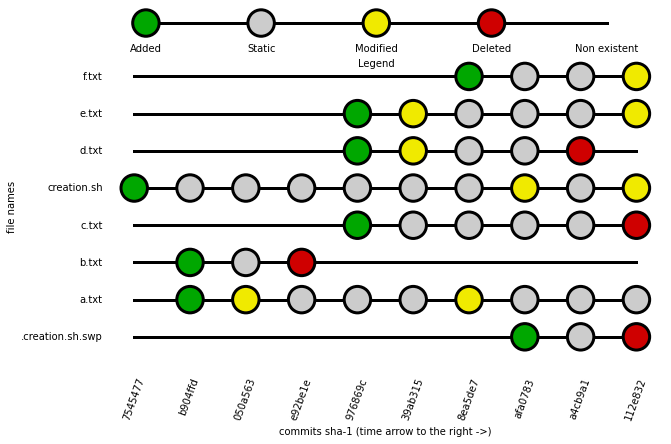

In [61]:
fig = plt.figure(figsize=[10,6])

ax = plt.subplot(111)
for i in range(len(all_files)):
    x = range(len(commits))
    y = [i for kk in x]
    ax.scatter(x, y, s = 700, c=h[i,:], alpha=1, marker='o',linewidths = 3 , cmap = plt.cm.spectral,vmin = 0, vmax = 255)
    ax.plot(x, y, lw = 3, c='k', zorder=0)
 
ax.set_xticks(range(history.shape[1]))
ax.set_xticklabels(all_filenames.columns,rotation=70)

ax.set_xlabel('commits sha-1 (time arrow to the right ->)')
ax.set_xlim([-.5,len(commits)-0.5])
ax.set_ylabel('file names')
ax.set_yticks(range(history.shape[0]))
ax.set_yticklabels(all_filenames.index.tolist())
ax.set_yticks = 0.1
# set 0 to bounding box width
[i.set_linewidth(0.0) for i in ax.spines.itervalues()]
# see http://stackoverflow.com/a/20416681/1435167
# erase x ticks
for tic in ax.xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
#     tic.label1On = tic.label2On = False
# erase y ticks
for tic in ax.yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
#     tic.label1On = tic.label2On = False

ax2 = fig.add_axes([0.1, .9, 0.8, 0.075])
 
colors = np.array(def_states.values()).astype('float')
colors[colors == 128] = np.nan

x = range(len(colors))
y = [1 for kk in x]
ax2.scatter(x, y, s = 700, c=colors, alpha=1, marker='o',linewidths = 3, cmap = plt.cm.spectral,vmin = 0, vmax = 255)
ax2.plot(x, y, lw = 3, c='k', zorder=0)
 
ax2.set_xticks(x)
ax2.set_xticklabels(def_states_explain.values())
ax2.set_xlabel('Legend')
ax2.set_xlim([-.5,len(x)-0.5])
ax2.set_ylim([0.99,1.01])
# set 0 to bounding box width
[i.set_linewidth(0.0) for i in ax2.spines.itervalues()]
# # see http://stackoverflow.com/a/20416681/1435167
# erase x ticks
for tic in ax2.xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
# erase y ticks
for tic in ax2.yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
    tic.label1On = tic.label2On = False

fig.savefig('/Users/damo_ma/Desktop/test.png')

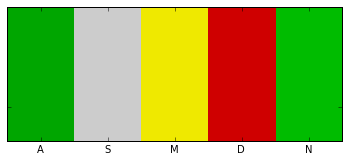

In [204]:
# fake legend
a = np.empty([2,len(def_states)])
a[0,:] = [k for k in def_states.itervalues()]
a[1,:] = a[0,:]
plt.imshow(a,interpolation='nearest',cmap = plt.cm.spectral,vmin = 0, vmax = 255 )
plt.xticks(range(len(def_states)), [k for k in def_states.iterkeys()]);
plt.yticks([1], '');

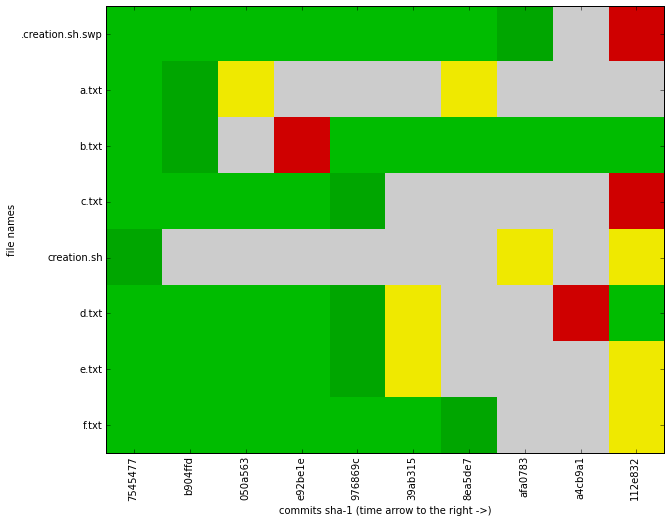

In [205]:
fig = plt.figure(figsize=[10,10])

plt.imshow(history,interpolation='nearest',cmap = plt.cm.spectral,vmin = 0, vmax = 255 )
plt.xticks(range(history.shape[1]), all_filenames.columns, rotation='vertical');
plt.xlabel('commits sha-1 (time arrow to the right ->)')
plt.ylabel('file names')
plt.yticks(range(history.shape[0]), all_filenames.index.tolist());